In [1]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
g = 9.81
vt = 4.9
CD = 1.0 / 5.0
CL = 1.0


v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0 = 2.0

In [4]:
def rhs_phugoid(u, CL, CD, g, vt):
    v, theta, x, y = u
    rhs = numpy.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs

def euler_step(u, f, dt, *args):
    u_new = u + dt * f(u, *args)
    return u_new

def l1_diff(u_coarse, u_fine, dt):
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

In [5]:
def rk2_step(u, f, dt, *args):
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

In [6]:
T = 15.0
dt = 0.01
N = int(T / dt) + 1

u_euler = numpy.empty((N, 4))
u_rk2 = numpy.empty((N, 4))

u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

for n in range(N - 1):
    u_euler[n + 1] = euler_step(u_euler[n], rhs_phugoid, dt,
                                CL, CD, g, vt)
    u_rk2[n + 1] = rk2_step(u_rk2[n], rhs_phugoid, dt,
                            CL, CD, g, vt)

In [7]:
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

In [8]:
idx_negative_euler = numpy.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N - 1
    print('[Euler] Glider has not touched ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]

idx_negative_rk2 = numpy.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[RK2] Glider has not touched ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [9]:
print('Are the x-values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


Distance traveled: 14.516


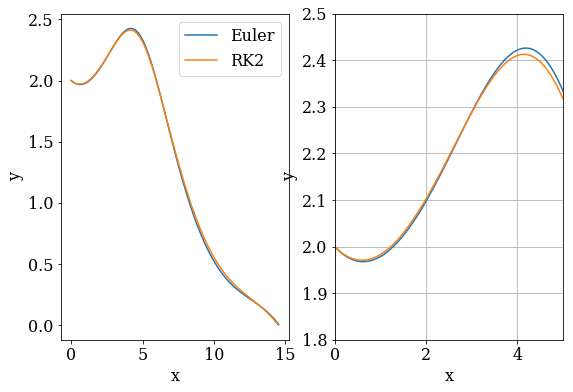

In [10]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
pyplot.legend();

pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler, y_euler, label='Euler')
pyplot.plot(x_rk2, y_rk2, label='RK2')
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [11]:
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)

In [12]:
diff_values = []
for u, dt in zip(u_values, dt_values):
    diff = l1_diff(u[:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

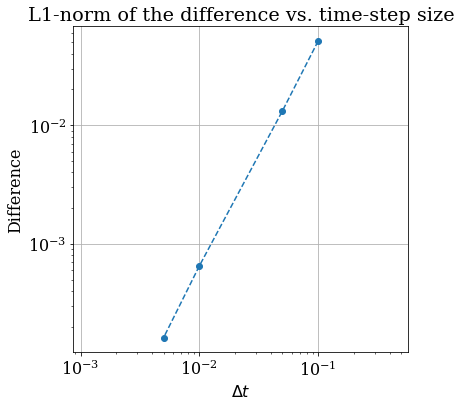

In [13]:
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm of the difference vs. time-step size')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Difference')
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values[:-1],
              color='C0', linestyle='--', marker='o')
pyplot.axis('equal');

In [14]:
r = 2
h = 0.001

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
    
p = (math.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
              l1_diff(u_values[1], u_values[0], dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 1.996


In [15]:
def leapfrog_step(u_prev, u, f, dt, *args):
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

In [16]:
g = 9.81
vt = 4.9
CD = 1.0 / 5.0
CL = 1.0


v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0 = 25.0

T = 35.0
dt = 0.01
N = int(T / dt) + 1

u_leapfrog = numpy.empty((N, 4))

u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])

u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

In [17]:
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n - 1], u_leapfrog[n],
                                      rhs_phugoid, dt, CL, CD, g, vt)

In [18]:
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Distance traveled: 123.917


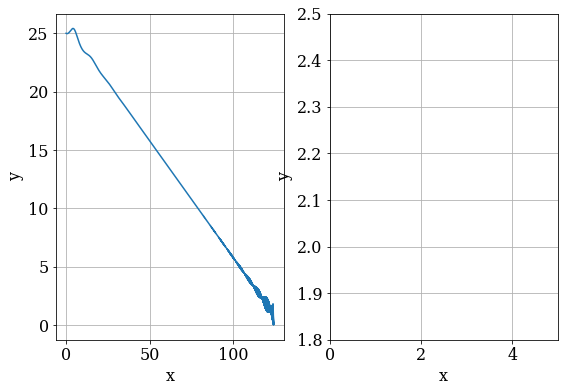

In [19]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])

pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog, y_leapfrog)
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [20]:
r = 2
h = 0.001

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    u_values.append(u)

p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                     dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 4.827
